In [1]:
# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm
import seaborn as sns
from scipy.stats import ttest_ind
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### SIMULATING A RCT DATA SET GENERATED FROM A DIRECT MKTING CAMPAIGN / E-COMMERCE A/B TEST ###

From my experience a very helpful thought experiment is to try to think about the data generating process behind a given data set. In the last few months I've been working with several randomized controlled trials data sets and quasi-experimental data sets generated by different marketing/operational process in an e-commerce platform.

Based on that experience I believe I have the enough maturity and understanding of the underlying business processes dynamics to try and generate a näive data generating process which will try to emulate the observed data distributions stemming from a typical RCT data set resulting from a marketing campaign.

##### 1. Lets define the MINIMAL OBSERVATION UNIT and start working our way from there! #####

For simplicity lets assume our minimal observational unit will be a given customer, in a real-world setting, one customer can receive several pushes and incentives in the form of marketing campaigns, hence the one-time effect of a campaign is diluted and entangled with several different effects originated with the set of campaigns which are triggered by the overall treatment policy definition for that given customer.

A direct approach to simulate a set of customers transactional behaviour is to simulate the purchase process as a mixture of a Bernoulli and a continous rv (log-normal for instance). First each customer will be characterized by a given purchase probability, then the number of valid transactions can be modelled as a number of repeated Bernoulli trials (a Binomial rv), finally the observed purchased amounts will be modelled as the product of this bernoulli rv and the defined continous rv.


In [2]:
# Number of Observations
SIZE = 10000

# Purchase Behaviour Number of valid transactions
n, p = 1, 0.2
purchase_prob = np.random.binomial(1, p, SIZE)

# Purchase Amounts
mu, sigma = 1, 1
purchase_amounts = np.random.lognormal(mu, sigma, SIZE)

# Purchase client vector (ie: total amount spent by a given customer)
total_spent_amount = purchase_prob * purchase_amounts

Finally we can generate some customer-level descriptive features such as age and gender.

In [3]:
age = np.random.choice(a=range(18,70), size=SIZE)
gender = np.random.choice(a=range(2), size=SIZE)

Lets consolidate the DGP into a pandas DataFrame for readibilty purposes.

In [4]:
trx_df = pd.DataFrame({'gender': gender,
                       'age': age, 
                       'total_purchase_amt':total_spent_amount})

Lets inspect the simulated data.

In [5]:
trx_df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,10000.0,0.491600,0.499954,0.0,0.0,0.0,1.0,1.000000
age,10000.0,43.657100,14.932335,18.0,31.0,44.0,56.0,69.000000
total_purchase_amt,10000.0,0.886005,3.134793,0.0,0.0,0.0,0.0,118.395626


##### 2. Now lets add average treatment effect incrementals as incrementals observed in the Treatment/Control groups! #####

Typically in an A/B testing or RCT (such as the one in defined by a RCT mkting campaign) one would expect to observe certain effects of the treatment in a set of transactional features, in order to encode this into our DGP we'll need to randomly select treatment/control groups and define an expected incremental ATE (avg. treatment effect). This is easy to do in a toy-example like this one however in a real-world application observed incremental effects are often diluted and is hard to pick up true signal amidst all the inherent noise present on a marketing campaign.

There are different approaches to simulate incremental ATE, a direct approach (perhaps näive) is to simulate two groups of customer, one with a baseline set of simulation parameters and the other one with a set of parameters with the incremental effect already encoded into them.
For simplicity lets assume we only observe an incremental ATE in the purchase rate for a given treatment policy, for this toy example let's assume the observed ATE post-treatment increases from 20% to 22%.

In [8]:
# Number of Observations
SIZE = 10000

# Purchase Behaviour Number of valid transactions
n, q = 1, 0.22
purchase_prob = np.random.binomial(1, q, SIZE)

# Purchase Amounts
mu, sigma = 1, 1
purchase_amounts = np.random.lognormal(mu, sigma, SIZE)

# Purchase client vector (ie: total amount spent by a given customer)
total_spent_amount = purchase_prob * purchase_amounts

age = np.random.choice(a=range(18,70), size=SIZE)
gender = np.random.choice(a=range(2), size=SIZE)
trx_df2 = pd.DataFrame({'gender': gender,
                       'age': age, 
                       'total_purchase_amt':total_spent_amount})

Now lets compare both groups to check if the purchase rate is indeed different between both groups of customers.

In [9]:
trx_df2['purchase_flag'] = np.where(trx_df2['total_purchase_amt']>0,1,0)
trx_df['purchase_flag'] = np.where(trx_df['total_purchase_amt']>0,1,0)
trx_df2.purchase_flag.mean() - trx_df.purchase_flag.mean()

0.020100000000000007

Now lets wrap all up in a convenient set of functions!

In [10]:
def sim_group(SampleSize, impulse):
    
    ### Reproducibility ###
    np.random.seed(1234)
    
    ### Sim Params ###
    SIZE, n, p, q, mu, sigma = (SampleSize/2), 1, 0.2, (0.2+impulse), 1, 1
    
    ### Sim Vars ###
    ControlPP, TreatmentPP = np.random.binomial(1, p, int(SIZE)), np.random.binomial(1, q, int(SIZE))
    _ControlPA, _TreatmentPA = np.random.lognormal(mu, sigma, int(SIZE)), np.random.lognormal(mu, sigma, int(SIZE))   
    ControlPA, TreatmentPA = (ControlPP * _ControlPA), (TreatmentPP * _TreatmentPA)
    _PurchaseAmount = np.append(ControlPA, TreatmentPA)
    _group = np.append(np.zeros(int(SIZE)), np.ones(int(SIZE)))
    age = np.random.choice(a=range(18,70), size=SampleSize)
    gender = np.random.choice(a=range(2), size=SampleSize)
    
    ### Sim Results ###
    _sim = pd.DataFrame({ 
                        'gender': gender,
                        'age': age,
                        'group':_group,
                        'total_purchase_amt': _PurchaseAmount})
    return _sim.sample(frac=1)

In [11]:
data = sim_group(1000, 0.02)

In [12]:
data['purchase_flag'] = np.where(data['total_purchase_amt']>0,1,0)
data.loc[data['group']==1].purchase_flag.mean() - data.loc[data['group']==0].purchase_flag.mean()

0.023999999999999994

In [13]:
data.loc[data['group']==1].total_purchase_amt.mean() - data.loc[data['group']==0].total_purchase_amt.mean()

0.13142355152042662

Lets inspect the simulated distributions due to the simulated ATE:

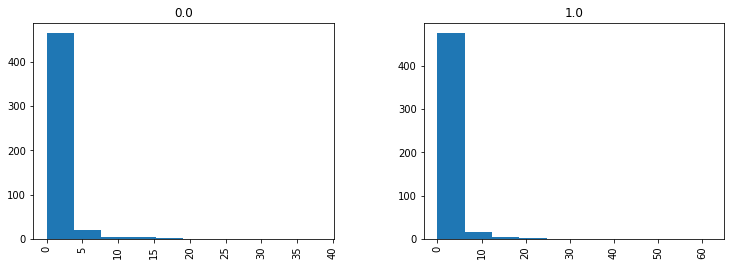

In [14]:
data.hist("total_purchase_amt", by="group", figsize=(12, 4));

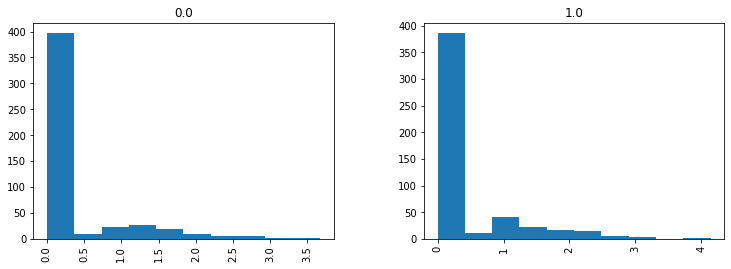

In [15]:
data['log_purchase_amt'] = np.log1p(data['total_purchase_amt'])
data.hist("log_purchase_amt", by="group", figsize=(12, 4));

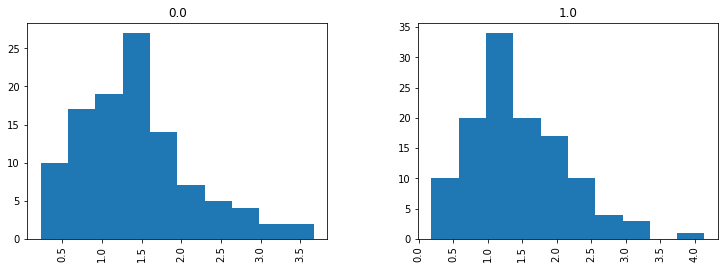

In [16]:
_msk = (data['purchase_flag']==1)
data.loc[_msk].hist("log_purchase_amt", by="group", figsize=(12, 4));

As a final thought is quite straight forward to modify these simple functions in order to simulate incrementals in the different business metrics that we've defined (total spents amounts, total number of units purchased, total number of valid transacionts, etc...).

Moreover is a very good excercise to modify these and observe how the incremental ATE are modified when several business metrics change at the same time, which is less näive than assuming univariate changes due to treatment policies.

### Bayesian and Frequentist Differences in Means to measure the simulated ATE ###

Frequentist approach: We can use a simple Z-test or T-test (which will yield roughly the same results for large samples) to compare the purchase amt mean between treatment and control group. A good practice is to always inspect the empirical means beforehand (aswell as the empirical variances) to get a sense of the size of the estimated ATE and if your current sample size you'll be able to actually measure some difference between both groups.

In [17]:
data.loc[data['group']==1].total_purchase_amt.mean() - data.loc[data['group']==0].total_purchase_amt.mean()

0.13142355152042662

In [18]:
ttest_ind(data.loc[data['group']==1].total_purchase_amt.values, data.loc[data['group']==0].total_purchase_amt.values, equal_var=False, alternative="two-sided")

Ttest_indResult(statistic=0.5754563466727853, pvalue=0.5651151799365699)

Given these results we can't reject the null hypothesis (ie: H0:E[Treatment] = E[Control]) with an alpha level of confidence (1%, 5% or 20%), hence it seems there's no difference between the means of the purchase amount between both groups, moreover we can't claim that the treatment was effective.

Bayesian approach: Following on Kruschke, John. (2012) Bayesian estimation supersedes the t-test. Journal of Experimental Psychology, we can build a bayesian aproximation to a classical t-test. In this setting instead of trying to test if both groups are different in a given metric we can build an estimation (Bayesian Model) of how different they are.

For this task Kruschke chooses the following three-parameter characterization a T-Student distribution with a specification of a mean , a precision (inverse-variance)  and a degrees-of-freedom parameter to control the level of normality.

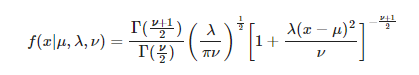

Furthermore with this characterization we can build the following likelihood functions:
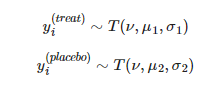

For simplicity lets assume that the degree of gaussianty (dof) is the same for both groups and that we'll have different mean and standard deviation parameters for each group.

In [19]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag
rng = np.random.default_rng(seed=1234)

Since the means are positive and real-valued lets apply log-normal priors to them with pooled mean and standard deviations.

In [20]:
μ_m = data.total_purchase_amt.mean()
μ_s = data.total_purchase_amt.std() 

with pm.Model() as model:
    group1_mean = pm.LogNormal("group1_mean", mu=μ_m, sigma=μ_s)
    group2_mean = pm.LogNormal("group2_mean", mu=μ_m, sigma=μ_s)

Popular choices for the standard deviation prior distribution are Gamma, Inverse-Gamma, Beta, etc... however for simplicity lets assume a less informative prior such as Half-Normal which is real-valued and also member of the exponential family of distributions, however is less-flexible and informative. An alternative and even less-informative choice would be a uniform prior over the hyper-prior.

In [21]:
with model:
    group1_std = pm.HalfNormal('group1_std', sigma=μ_s)
    group2_std = pm.HalfNormal('group2_std', sigma=μ_s)

For the degrees of freedom lets follow Kruschke's suggestion and assume an exponential prior with a high mean in order to give more weight to regions of the parameter which are more gaussian and less heavy-tailed.

In [22]:
with model:
    ν = pm.Exponential("ν_minus_one", 1 / 1999) + 1

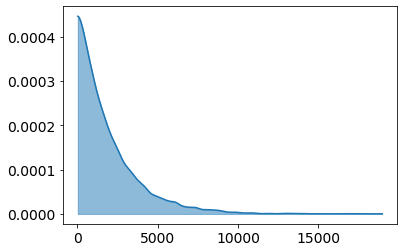

In [23]:
az.plot_kde(rng.exponential(scale=2000, size=10000), fill_kwargs={"alpha": 0.5});

Given that the parametrization is based on a precition paramter rather than the variance, lets transform the standard deviations before defining the likelihood functions.

In [24]:
with model:
    λ1 = group1_std ** -2
    λ2 = group2_std ** -2

    group1 = pm.StudentT("treatment", nu=ν, mu=group1_mean, lam=λ1, observed=data.loc[data['group']==1])
    group2 = pm.StudentT("control", nu=ν, mu=group2_mean, lam=λ2, observed=data.loc[data['group']==0])

In [25]:
with model:
    diff_of_means = pm.Deterministic("difference of means", group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic("difference of stds", group1_std - group2_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((group1_std ** 2 + group2_std ** 2) / 2)
    )

In [ ]:
with model:
    trace = pm.sample(500, return_inferencedata=True)

In [ ]:
az.plot_forest(trace, var_names=["group1_mean", "group2_mean"]);

In [ ]:
az.plot_posterior(
    trace,
    var_names=["difference of means"],
    ref_val=0,
    color="#87ceeb",
);

In [ ]:
az.summary(trace, var_names=["difference of means", "difference of stds", "effect size"])

In [ ]:
blue_rate_samples = trace.posterior['blue_rate'].values
red_rate_samples = trace.posterior['red_rate'].values
print(f'Probability that red is better: {(red_rate_samples > blue_rate_samples).mean():.1%}.')

Sources:
1. Gelman. (2014). Bayesian data analysis (Third edition.). CRC Press.

2. Kruschke. (2013). Bayesian Estimation Supersedes the t Test. Journal of Experimental Psychology. General, 142(2), 573–603. https://doi.org/10.1037/a0029146

3. https://towardsdatascience.com/bayesian-a-b-testing-in-pymc3-54dceb87af74